# **Analisis del COVID-19**
El COVID-19 es un virus respiratorio surgido en la provincia de Wuhan (China). Actualmente la OMS ha etiquetado como **pandemia** la propagación de este virus a lo largo del mundo.

Los datos usados son los proporcionados por la **[Jonh Hopkins University](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)**. Estos datos se actualizan cada 24 Horas.

Se pueden descargar a traves de **[Github](https://github.com/CSSEGISandData/COVID-19)**

![texto alternativo](https://s7d2.scene7.com/is/image/TWCNews/0304_n13_covid_19_coronavirus_graphic_generic_file)

El notebook consta de dos partes:


1.   Visualización y prediccion mediante SVM y Regresión Polimómica
2.   Modelo SEIR (Caso de España)





##**Parte 1 Visualización y SVM y PolynomialRegression**

Cargamos las librerias necesarias

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd



import folium
from folium.plugins import HeatMap
import math
import pandas_profiling

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from scipy import stats
import random
import math
import time
from datetime import datetime, timedelta
import sys

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error



import datetime
plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

Clonamos github para usar el data set y cargamos los df

In [0]:
! git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17505 (delta 7), reused 13 (delta 5), pack-reused 17475
Receiving objects: 100% (17505/17505), 68.29 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (8816/8816), done.


In [0]:
confirmed = pd.read_csv('/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', error_bad_lines=False)
deaths = pd.read_csv('/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', error_bad_lines=False)
recovered = pd.read_csv('/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', error_bad_lines=False)

display(confirmed.head(), deaths.head(), recovered.head())

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


# **Visualización de COVID-19**
Vamos a proceder a hacer una analisis exploratorio de los datos, viendo en el mundo y en este caso también en España como evolucionan dia a dia

Primero de todo realizaremos un unpivot para deshacer el formato ancho y alargarlo. Más info: **[Unpivot pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html)**



In [0]:
confirmed1=pd.melt(confirmed, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], 
                   var_name='DateTime', value_name='Confirmed')
deaths1=pd.melt(deaths, id_vars=['Province/State', 'Country/Region', 'Lat','Long'],
                var_name='DateTime', value_name='Deaths')
recovered1=pd.melt(recovered, id_vars=['Province/State', 'Country/Region', 'Lat','Long'],
                   var_name='DateTime', value_name='Recovered')

# visualizamos los nuevos data frames
display(confirmed1.head(), deaths1.head(), recovered1.head())

,Province/State,Country/Region,Lat,Long,DateTime,Confirmed
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0


,Province/State,Country/Region,Lat,Long,DateTime,Deaths
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0


,Province/State,Country/Region,Lat,Long,DateTime,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0


Comprobamos el  número de NaN's que existe en los df

In [0]:
display(confirmed1.isnull().sum(),
deaths1.isnull().sum(),
recovered1.isnull().sum())

Province/State    12567
Country/Region        0
Lat                   0
Long                  0
DateTime              0
Confirmed             0
dtype: int64

Province/State    12567
Country/Region        0
Lat                   0
Long                  0
DateTime              0
Deaths                0
dtype: int64

Province/State    12638
Country/Region        0
Lat                   0
Long                  0
DateTime              0
Recovered             0
dtype: int64

In [0]:
# Rellenamos NaN en la columna Province/State con datos de Country/Region
deaths1['Province/State'] = deaths1['Province/State'].fillna(deaths1['Country/Region'])
recovered1['Province/State'] = recovered1['Province/State'].fillna(recovered1['Country/Region'])
confirmed1['Province/State'] = confirmed1['Province/State'].fillna(confirmed1['Country/Region'])

Cambiamos el tipo de dato en la Columna DateTime

In [0]:
confirmed1['DateTime'] = pd.to_datetime(confirmed1['DateTime'])
deaths1['DateTime'] = pd.to_datetime(deaths1['DateTime'])
recovered1['DateTime'] = pd.to_datetime(recovered1['DateTime'])


Union de df's, mediante la funcion de pandas 'merge'

In [0]:
merge = pd.merge(confirmed1, deaths1, how='left', left_on=['Province/State', 'DateTime'],
                 right_on = ['Province/State', 'DateTime'])

full_data = pd.merge(merge, recovered1, how='left', left_on=['Province/State', 'DateTime'],
                 right_on = ['Province/State', 'DateTime'])

Cambiamos a int las columnas de Recovered, Deaths, Confirmed

In [0]:
full_data['Recovered']= pd.to_numeric(full_data['Recovered'], downcast='integer')
full_data['Deaths']= pd.to_numeric(full_data['Deaths'], downcast='integer')
full_data['Confirmed']= pd.to_numeric(full_data['Confirmed'], downcast='integer')

Eliminamos las columnas duplicadas generadas en el merge 'Lat_y', 'Long_y', 'Lat', 'Long', 'Country/Region', 'Country/Region_y', para no alterar el orden de las columnas de los data frame originales. Renombramos las columnas 'Country/Region_x', 'Lat_x', 'Long_x'

Creamos una nueva columna con los casos activos

In [0]:
full_data.drop(columns=['Lat_y', 'Long_y', 'Lat', 'Long', 'Country/Region', 'Country/Region_y', 'Province/State'], inplace=True)


full_data.rename(columns={'Country/Region_x':'Country/Region', 'Lat_x':'Lat', 'Long_x':'Long'},
                  inplace=True)

full_data['Active'] = full_data['Confirmed']-full_data['Deaths']-full_data['Recovered']

Mediante el siguiente código vemos actualizados los datos con los que vamos a trabajar

In [0]:
ult_actualizacion = full_data['DateTime'].max()
ult_actualizacion_Filter= full_data['DateTime']==ult_actualizacion

casos_totales_actualizados = full_data[ult_actualizacion_Filter]

casos_totales_actualizados.sort_values(by=['Confirmed'], inplace=True, ascending=False)
casos_totales_actualizados.reset_index(0, drop=True, inplace=True)
casos_totales_actualizados['Active'] = casos_totales_actualizados['Confirmed']-casos_totales_actualizados['Deaths']-casos_totales_actualizados['Recovered']

TotalConf=casos_totales_actualizados['Confirmed'].sum()
TotalDeaths=casos_totales_actualizados['Deaths'].sum()
TotalRecovered=casos_totales_actualizados['Recovered'].sum()
TotalActive=casos_totales_actualizados['Active'].sum()
EstMortalityRate=TotalDeaths/TotalConf

print("Última actualización", ult_actualizacion.strftime('%d %b %Y'), sep=": ")
print("Total Confirmados", '{:,}'.format(TotalConf), sep=": ")
print("Total Muertes", '{:,}'.format(TotalDeaths), sep=": ")
print("Total Recuperados", '{:,}'.format(TotalRecovered), sep=": ")
print("Casos Activos",'{:,}'.format(TotalActive), sep=": ")
print("Ratio de mortalidad",'{:.2%}'.format(EstMortalityRate), sep=": " )

Última actualización: 01 Apr 2020
Total Confirmados: 933,317
Total Muertes: 46,821
Total Recuperados: 193,662.0
Casos Activos: 683,382.0
Ratio de mortalidad: 5.02%


# Visualizamos en el mundo los casos que hay actualmente

In [0]:
map = folium.Map(location=[20, 60], tiles = 'openstreetmap', zoom_start=4.2)
casos_totales_actualizados['Confirmed']= casos_totales_actualizados['Confirmed'].astype(float)
casos_totales_actualizados['Deaths']= casos_totales_actualizados['Deaths'].astype(float)
casos_totales_actualizados['Recovered']= casos_totales_actualizados['Recovered'].astype(float)
for i in range(0,len(casos_totales_actualizados)):
   folium.Circle(
      location=[casos_totales_actualizados.iloc[i]['Lat'], casos_totales_actualizados.iloc[i]['Long']],
      popup=
              casos_totales_actualizados.iloc[i]['Country/Region']+ 
       " Total Confirmed: "+str("{:,.0f}".format(casos_totales_actualizados.iloc[i]['Confirmed']))+
       " Total Deaths: "+ str("{:,.0f}".format(casos_totales_actualizados.iloc[i]['Deaths']))+
       " Total Recovered: "+ str("{:,.0f}".format(casos_totales_actualizados.iloc[i]['Recovered']))+
       " Total Active: "+ str("{:,.0f}".format(casos_totales_actualizados.iloc[i]['Active'])),
      radius=(math.sqrt(casos_totales_actualizados.iloc[i]['Confirmed'])*1200+2 ),
      tooltip = '<li><bold>Country : '+str(casos_totales_actualizados.iloc[i]['Country/Region'])+
                '<li><bold>Confirmed : '+str("{:,.0f}".format(casos_totales_actualizados.iloc[i]['Confirmed']))+
                '<li><bold>Deaths : '+str("{:,.0f}".format(casos_totales_actualizados.iloc[i]['Deaths']))+
                '<li><bold>Recovered : '+str("{:,.0f}".format(casos_totales_actualizados.iloc[i]['Recovered']))+
                '<li><bold>Active : '+str("{:,.0f}".format(casos_totales_actualizados.iloc[i]['Active'])),
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(map)
folium.TileLayer("CartoDB dark_matter").add_to(map)
folium.TileLayer('Stamen Terrain').add_to(map)
folium.TileLayer('Stamen Toner').add_to(map)
folium.TileLayer('stamenwatercolor').add_to(map)
folium.TileLayer('cartodbpositron').add_to(map)
folium.LayerControl().add_to(map)

map

A traves de la siguiente tabla obtenemos los casos distribuidos por países

In [0]:
casos_totales_country=casos_totales_actualizados.groupby(['Country/Region'], sort=False)['Confirmed', 'Deaths', 'Recovered', 'Active'].sum()
casos_totales_country=casos_totales_country.reset_index()
print("Última Actualización", ult_actualizacion.strftime('%d %b %Y'), sep=": ")
display(casos_totales_country.style.background_gradient(cmap='Reds', text_color_threshold = .1))

Última Actualización: 01 Apr 2020


,Country/Region,Confirmed,Deaths,Recovered,Active
0,US,213372.000000,4757.000000,8474.000000,200141.000000
1,Italy,110574.000000,13155.000000,16847.000000,80572.000000
2,Spain,104118.000000,9387.000000,22647.000000,72084.000000
3,Germany,77872.000000,920.000000,18700.000000,58252.000000
4,China,82361.000000,3316.000000,76405.000000,2640.000000
5,France,57749.000000,4043.000000,11053.000000,42653.000000
6,Iran,47593.000000,3036.000000,15473.000000,29084.000000
7,United Kingdom,29865.000000,2357.000000,179.000000,27329.000000
8,Switzerland,17768.000000,488.000000,2967.000000,14313.000000
9,Turkey,15679.000000,277.000000,333.000000,15069.000000


Vemos la evolución del virús a nivel mundial y en España, Italia y China

In [0]:
TotalCases=full_data.groupby(['DateTime']).agg({"Confirmed": sum, 'Deaths': sum, 'Recovered': sum, 'Active': sum})
TotalCases=TotalCases.reset_index()

# Evolución COVID-19
fig = go.Figure()
fig.add_trace(go.Scatter(x = TotalCases.DateTime, y = TotalCases['Confirmed'], name = "Total Confirmados", line_color = 'orange', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = TotalCases.DateTime, y = TotalCases['Recovered'], name = "Total Recuperados", line_color = 'green', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = TotalCases.DateTime, y = TotalCases['Deaths'], name = "Total Muertes", line_color = 'firebrick', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.update_layout(title_text = 'Linea Total Casos en el Mundo',
  paper_bgcolor='rgba(233,233,233,233)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()


# Evolución de los casos activos
fig = go.Figure()
fig.add_trace(go.Scatter(x = TotalCases.DateTime, y = TotalCases['Active'], name = "Total Casos Activos", line_color = 'blue', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.update_layout(title_text = 'Linea Casos Activos en el Mundo', showlegend=True,
  paper_bgcolor='rgba(233,233,233,233)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [0]:
espan= full_data[full_data['Country/Region']== 'Spain']
espan = espan.groupby(['DateTime']).agg({"Confirmed": sum, 'Deaths': sum, 'Recovered': sum, 'Active': sum}).reset_index()

italy = full_data[full_data['Country/Region']== 'Italy']
italy = italy.groupby(['DateTime']).agg({"Confirmed": sum, 'Deaths': sum, 'Recovered': sum, 'Active': sum}).reset_index()

china = full_data[full_data['Country/Region']== 'China']
china = china.groupby(['DateTime']).agg({"Confirmed": sum, 'Deaths': sum, 'Recovered': sum, 'Active': sum}).reset_index()

In [0]:
# España
fig = go.Figure()
fig.add_trace(go.Scatter(x = espan.DateTime, y = espan['Confirmed'], name = "Total Confirmados", line_color = 'orange', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = espan.DateTime, y = espan['Recovered'], name = "Total Recuperados", line_color = 'green', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = espan.DateTime, y = espan['Deaths'], name = "Total Muertes", line_color = 'firebrick', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = espan.DateTime, y = espan['Active'], name = "Total Casos Activos", line_color = 'black', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.update_layout(title_text = 'Linea Total Casos en España',
  paper_bgcolor='rgba(233,233,233,233)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()


In [0]:

# Italia
fig = go.Figure()
fig.add_trace(go.Scatter(x = italy.DateTime, y = italy['Confirmed'], name = "Total Confirmados", line_color = 'orange', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = italy.DateTime, y = italy['Recovered'], name = "Total Recuperados", line_color = 'green', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = italy.DateTime, y = italy['Deaths'], name = "Total Muertes", line_color = 'firebrick', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = italy.DateTime, y = italy['Active'], name = "Total Casos Activos", line_color = 'black', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.update_layout(title_text = 'Linea Total Casos en Italia',
  paper_bgcolor='rgba(233,233,233,233)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()




In [0]:
#China
fig = go.Figure()
fig.add_trace(go.Scatter(x = china.DateTime, y = china['Confirmed'], name = "Total Confirmados", line_color = 'orange', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = china.DateTime, y = china['Recovered'], name = "Total Recuperados", line_color = 'green', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = china.DateTime, y = china['Deaths'], name = "Total Muertes", line_color = 'firebrick', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.add_trace(go.Scatter(x = china.DateTime, y = china['Active'], name = "Total Casos Activos", line_color = 'black', mode = 'lines+markers', marker = dict(size = 9, symbol = 'circle')))
fig.update_layout(title_text = 'Linea Total Casos en China',
    paper_bgcolor='rgba(233,233,233,233)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()

# Procesado y predicccion

Definimos el número de días desde el inicio y haremos una predicción de 15 días. Definimos el comienzo de la infección

In [0]:
desde_22_1 = np.array([i for i in range(len(TotalCases['DateTime']))]).reshape(-1, 1)
casos_confirmados = np.array(TotalCases['Confirmed']).reshape(-1, 1)
total_muertes = np.array(TotalCases['Deaths']).reshape(-1, 1)


In [0]:
dias = 15
prediccion =  np.array([i for i in range(len(TotalCases['DateTime']) + dias)]).reshape(-1, 1)
ajuste_de_fechas = prediccion[:-15]

In [0]:
comienzo= '1/22/2020'
fecha_comienzo = datetime.datetime.strptime(comienzo, '%m/%d/%Y')
fechas_prediccion = []
for i in range(len(prediccion)):
  fechas_prediccion.append((fecha_comienzo + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
# División del dataset para casos mundiales
X_train, X_test, y_train, y_test = train_test_split(desde_22_1, casos_confirmados, test_size=0.1, shuffle=False) 

In [0]:
# Definimos cuales son los mejores parametros para la SVR

# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5, 6, 7]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train, y_train)
# svm_search.best_params_

SVR mundial

In [0]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=8, C=0.1)
svm_confirmed.fit(X_train, y_train)
svm_pred = svm_confirmed.predict(prediccion)

In [0]:
svm_test_pred = svm_confirmed.predict(X_test)
print('MAE:', mean_absolute_error(svm_test_pred, y_test))
print('MSE:',mean_squared_error(svm_test_pred, y_test))

MAE: 59765.02792537282
MSE: 5178788585.41668


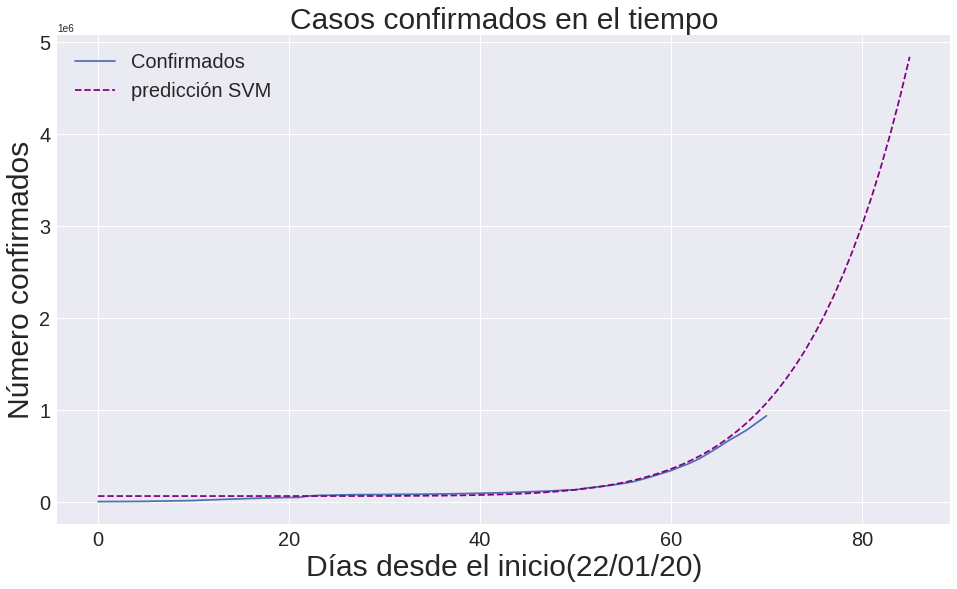

In [0]:
plt.figure(figsize=(16, 9))
plt.plot(ajuste_de_fechas, casos_confirmados)
plt.plot(prediccion, svm_pred, linestyle='dashed', color='purple')
plt.title('Casos confirmados en el tiempo', size=30)
plt.xlabel('Días desde el inicio(22/01/20)', size=30)
plt.ylabel('Número confirmados', size=30)
plt.legend(['Confirmados', 'predicción SVM'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [0]:
print('Predicciones SVm:')
set(zip(fechas_prediccion[-15:], np.round(svm_pred[-15:])))

Predicciones SVm:


{('04/02/2020', 1192733.0),
 ('04/03/2020', 1326784.0),
 ('04/04/2020', 1474521.0),
 ('04/05/2020', 1637125.0),
 ('04/06/2020', 1815860.0),
 ('04/07/2020', 2012079.0),
 ('04/08/2020', 2227228.0),
 ('04/09/2020', 2462851.0),
 ('04/10/2020', 2720595.0),
 ('04/11/2020', 3002219.0),
 ('04/12/2020', 3309593.0),
 ('04/13/2020', 3644710.0),
 ('04/14/2020', 4009690.0),
 ('04/15/2020', 4406784.0),
 ('04/16/2020', 4838385.0)}

Ahora la regresión polinomica a nivel mundial

In [0]:
poly = PolynomialFeatures(degree=6)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly_prediccion = poly.fit_transform(prediccion)


In [0]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
test_linear_pred = linear_model.predict(poly_X_test)
linear_pred = linear_model.predict(poly_prediccion)
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))


MAE: 21311.011285658606
MSE: 938957071.6764476


In [0]:
print(linear_model.coef_)

[[ 2.63666267e+03 -1.91971669e+03  4.19459177e+02 -1.36094565e+01
   2.18366535e-01 -3.21401527e-03  3.31914812e-05]]


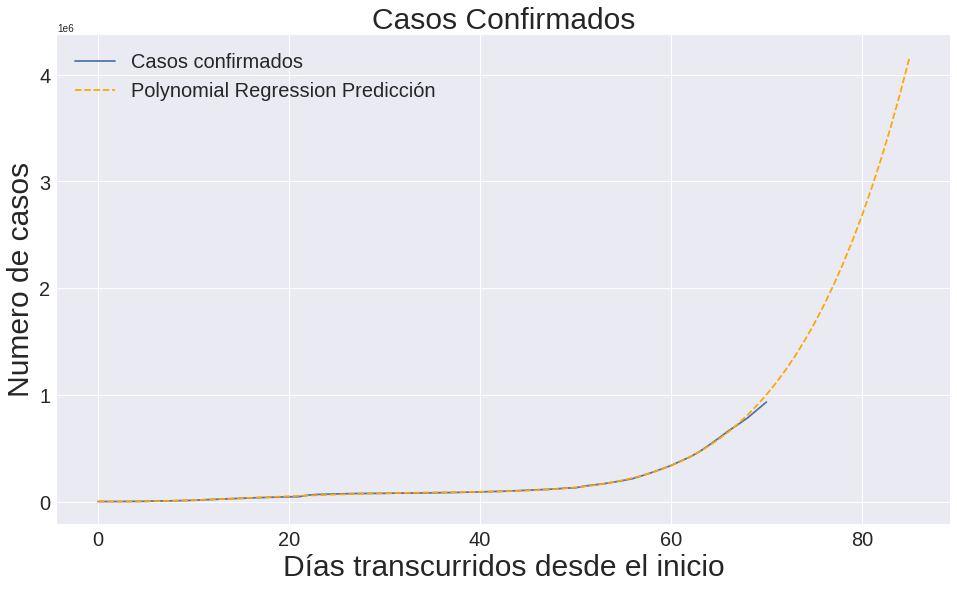

In [0]:
plt.figure(figsize=(16, 9))
plt.plot(ajuste_de_fechas, casos_confirmados)
plt.plot(prediccion, linear_pred, linestyle='dashed', color='orange')
plt.title('Casos Confirmados', size=30)
plt.xlabel('Días transcurridos desde el inicio', size=30)
plt.ylabel('Numero de casos', size=30)
plt.legend(['Casos confirmados', 'Polynomial Regression Predicción'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [0]:
linear_pred = linear_pred.reshape(1,-1)[0]
print('Predicción mediante regresión polinomial:')
set(zip(fechas_prediccion[-15:], np.round(linear_pred[-15:])))

Predicción mediante regresión polinomial:


{('04/02/2020', 1111935.0),
 ('04/03/2020', 1232727.0),
 ('04/04/2020', 1364834.0),
 ('04/05/2020', 1509058.0),
 ('04/06/2020', 1666242.0),
 ('04/07/2020', 1837271.0),
 ('04/08/2020', 2023076.0),
 ('04/09/2020', 2224629.0),
 ('04/10/2020', 2442952.0),
 ('04/11/2020', 2679112.0),
 ('04/12/2020', 2934228.0),
 ('04/13/2020', 3209467.0),
 ('04/14/2020', 3506052.0),
 ('04/15/2020', 3825256.0),
 ('04/16/2020', 4168410.0)}

Vemos que para este caso la regresión polinomial se ajusta mas que la SVM

España

In [0]:
desde_22_1_spain = np.array([i for i in range(len(espan['DateTime']))]).reshape(-1, 1)
casos_confirmados_spain = np.array(espan['Confirmed']).reshape(-1, 1)
total_muertes_spain = np.array(espan['Deaths']).reshape(-1, 1)

prediccion_spain =  np.array([i for i in range(len(espan['DateTime']) + dias)]).reshape(-1, 1)
ajuste_de_fechas_spain = prediccion_spain[:-15]

fechas_prediccion_spain = []
for i in range(len(prediccion_spain)):
  fechas_prediccion_spain.append((fecha_comienzo + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))


In [0]:
X_train_spain, X_test_spain, y_train_spain, y_test_spain = train_test_split(desde_22_1_spain, casos_confirmados_spain, test_size=0.05, shuffle=False) 

In [0]:
svm_confirmed.fit(X_train_spain, y_train_spain)
svm_pred_spain = svm_confirmed.predict(prediccion_spain)

In [0]:
svm_test_pred_spain = svm_confirmed.predict(X_test_spain)
print('MAE:', mean_absolute_error(svm_test_pred_spain, y_test_spain))
print('MSE:',mean_squared_error(svm_test_pred_spain, y_test_spain))

MAE: 24854.62476132628
MSE: 657219061.6103948


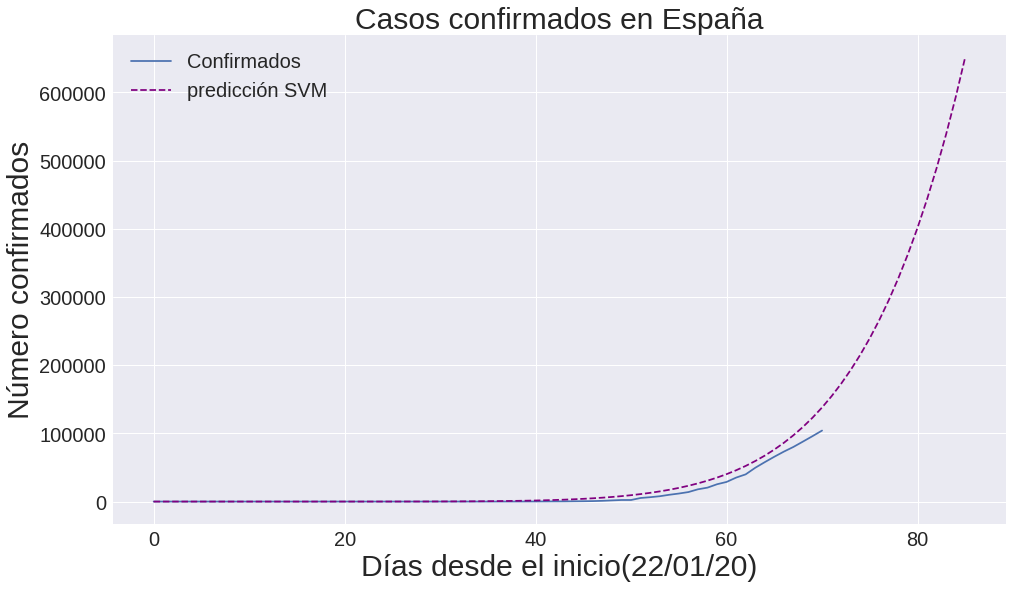

Predicción SVM:


{('04/02/2020', 154549.0),
 ('04/03/2020', 172847.0),
 ('04/04/2020', 193014.0),
 ('04/05/2020', 215210.0),
 ('04/06/2020', 239607.0),
 ('04/07/2020', 266392.0),
 ('04/08/2020', 295760.0),
 ('04/09/2020', 327923.0),
 ('04/10/2020', 363106.0),
 ('04/11/2020', 401549.0),
 ('04/12/2020', 443506.0),
 ('04/13/2020', 489250.0),
 ('04/14/2020', 539071.0),
 ('04/15/2020', 593275.0),
 ('04/16/2020', 652190.0)}

In [0]:
plt.figure(figsize=(16, 9))
plt.plot(ajuste_de_fechas_spain, casos_confirmados_spain)
plt.plot(prediccion_spain, svm_pred_spain, linestyle='dashed', color='purple')
plt.title('Casos confirmados en España', size=30)
plt.xlabel('Días desde el inicio(22/01/20)', size=30)
plt.ylabel('Número confirmados', size=30)
plt.legend(['Confirmados', 'predicción SVM'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


print('Predicción SVM:')
set(zip(fechas_prediccion_spain[-15:], np.round(svm_pred_spain[-15:])))

Italia

In [0]:
desde_22_1_italy = np.array([i for i in range(len(italy['DateTime']))]).reshape(-1, 1)
casos_confirmados_italy = np.array(italy['Confirmed']).reshape(-1, 1)
total_muertes_italy = np.array(italy['Deaths']).reshape(-1, 1)

prediccion_italy =  np.array([i for i in range(len(italy['DateTime']) + dias)]).reshape(-1, 1)
ajuste_de_fechas_italy = prediccion_italy[:-15]

fechas_prediccion_italy = []
for i in range(len(prediccion_italy)):
  fechas_prediccion_italy.append((fecha_comienzo + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))


X_train_italy, X_test_italy, y_train_italy, y_test_italy = train_test_split(desde_22_1_italy, casos_confirmados_italy, test_size=0.1, shuffle=False) 

svm_confirmed.fit(X_train_italy, y_train_italy)
svm_pred_italy = svm_confirmed.predict(prediccion_italy)

svm_test_pred_italy = svm_confirmed.predict(X_test_italy)
print('MAE:', mean_absolute_error(svm_test_pred_italy, y_test_italy))
print('MSE:',mean_squared_error(svm_test_pred_italy, y_test_italy))



MAE: 41399.20909899674
MSE: 2353299684.9010577


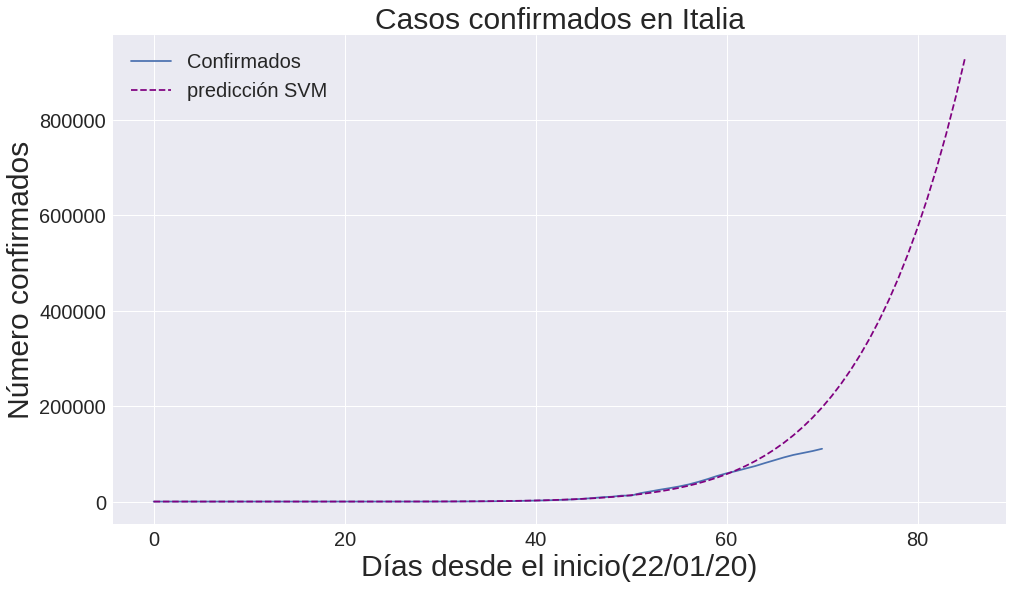

Predicción SVM:


{('04/02/2020', 220765.0),
 ('04/03/2020', 246901.0),
 ('04/04/2020', 275706.0),
 ('04/05/2020', 307410.0),
 ('04/06/2020', 342258.0),
 ('04/07/2020', 380516.0),
 ('04/08/2020', 422465.0),
 ('04/09/2020', 468405.0),
 ('04/10/2020', 518659.0),
 ('04/11/2020', 573568.0),
 ('04/12/2020', 633498.0),
 ('04/13/2020', 698837.0),
 ('04/14/2020', 769999.0),
 ('04/15/2020', 847422.0),
 ('04/16/2020', 931573.0)}

In [0]:
plt.figure(figsize=(16, 9))
plt.plot(ajuste_de_fechas_italy, casos_confirmados_italy)
plt.plot(prediccion_italy, svm_pred_italy, linestyle='dashed', color='purple')
plt.title('Casos confirmados en Italia', size=30)
plt.xlabel('Días desde el inicio(22/01/20)', size=30)
plt.ylabel('Número confirmados', size=30)
plt.legend(['Confirmados', 'predicción SVM'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

 
print('Predicción SVM:')
set(zip(fechas_prediccion_italy[-15:], np.round(svm_pred_italy[-15:])))

China

In [0]:
desde_22_1_china = np.array([i for i in range(len(china['DateTime']))]).reshape(-1, 1)
casos_confirmados_china = np.array(china['Confirmed']).reshape(-1, 1)
total_muertes_china = np.array(china['Deaths']).reshape(-1, 1)

prediccion_china =  np.array([i for i in range(len(china['DateTime']) + dias)]).reshape(-1, 1)
ajuste_de_fechas_china = prediccion_china[:-15]

fechas_prediccion_china = []
for i in range(len(prediccion_china)):
  fechas_prediccion_china.append((fecha_comienzo + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))


X_train_china, X_test_china, y_train_china, y_test_china = train_test_split(desde_22_1_china, casos_confirmados_china, test_size=0.1, shuffle=False) 

svm_confirmed.fit(X_train_china, y_train_china)
svm_pred_china = svm_confirmed.predict(prediccion_china)

svm_test_pred_china = svm_confirmed.predict(X_test_china)
print('MAE:', mean_absolute_error(svm_test_pred_china, y_test_china))
print('MSE:',mean_squared_error(svm_test_pred_china, y_test_china))

MAE: 40935.05538076986
MSE: 1873130061.9601777


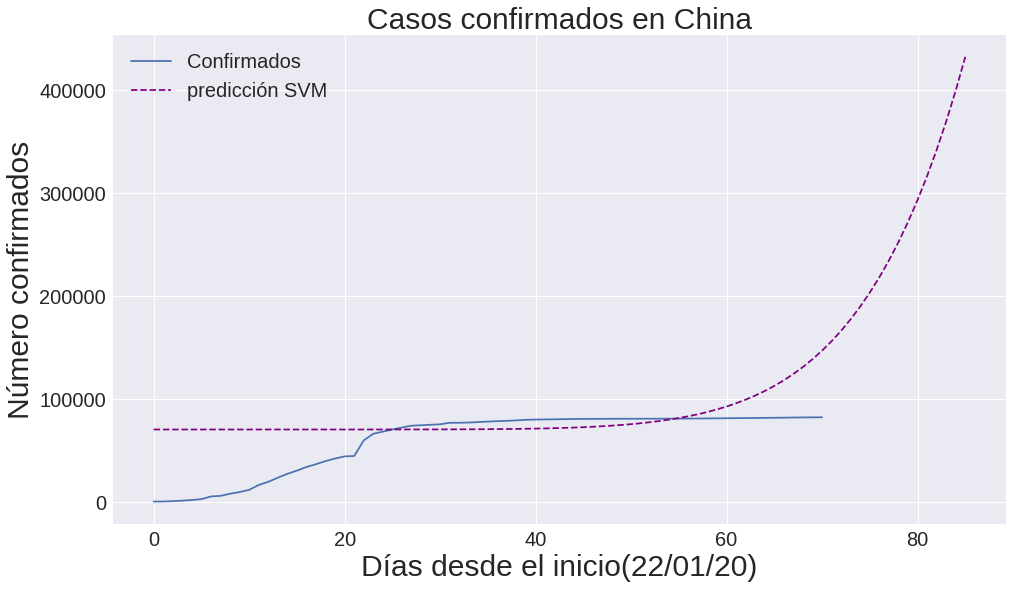

Predicción SVM:


{('04/02/2020', 156231.0),
 ('04/03/2020', 166380.0),
 ('04/04/2020', 177565.0),
 ('04/05/2020', 189876.0),
 ('04/06/2020', 203409.0),
 ('04/07/2020', 218265.0),
 ('04/08/2020', 234554.0),
 ('04/09/2020', 252393.0),
 ('04/10/2020', 271908.0),
 ('04/11/2020', 293230.0),
 ('04/12/2020', 316501.0),
 ('04/13/2020', 341874.0),
 ('04/14/2020', 369507.0),
 ('04/15/2020', 399571.0),
 ('04/16/2020', 432249.0)}

In [0]:
plt.figure(figsize=(16, 9))
plt.plot(ajuste_de_fechas_china, casos_confirmados_china)
plt.plot(prediccion_china, svm_pred_china, linestyle='dashed', color='purple')
plt.title('Casos confirmados en China', size=30)
plt.xlabel('Días desde el inicio(22/01/20)', size=30)
plt.ylabel('Número confirmados', size=30)
plt.legend(['Confirmados', 'predicción SVM'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

 
print('Predicción SVM:')
set(zip(fechas_prediccion_china[-15:], np.round(svm_pred_china[-15:])))

PolynomialRegression

In [0]:
#españa
poly_X_train_spain = poly.fit_transform(X_train_spain)
poly_X_test_spain = poly.fit_transform(X_test_spain)
poly_prediccion_spain = poly.fit_transform(prediccion_spain)

#italia
poly_X_train_italy = poly.fit_transform(X_train_italy)
poly_X_test_italy = poly.fit_transform(X_test_italy)
poly_prediccion_italy = poly.fit_transform(prediccion_italy)

#china
poly_X_train_china = poly.fit_transform(X_train_china)
poly_X_test_china = poly.fit_transform(X_test_china)
poly_prediccion_china = poly.fit_transform(prediccion_china)


In [0]:
linear_model_spain = LinearRegression(normalize=True, fit_intercept=False)
linear_model_spain.fit(poly_X_train, y_train)
test_linear_pred_spain = linear_model_spain.predict(poly_X_test_spain)
linear_pred_spain = linear_model_spain.predict(poly_prediccion_spain)
print('MAE España:', mean_absolute_error(test_linear_pred_spain, y_test_spain))
print('MSE España:',mean_squared_error(test_linear_pred_spain, y_test_spain))

linear_model_italy = LinearRegression(normalize=True, fit_intercept=False)
linear_model_italy.fit(poly_X_train_italy, y_train_italy)
test_linear_pred_italy = linear_model_italy.predict(poly_X_test_italy)
linear_pred_italy = linear_model_italy.predict(poly_prediccion_italy)
print('MAE Italia:', mean_absolute_error(test_linear_pred_italy, y_test_italy))
print('MSE Italia:',mean_squared_error(test_linear_pred_italy, y_test_italy))

linear_model_china = LinearRegression(normalize=True, fit_intercept=False)
linear_model_china.fit(poly_X_train_china, y_train_china)
test_linear_pred_china = linear_model_china.predict(poly_X_test_china)
linear_pred_china = linear_model_china.predict(poly_prediccion_china)
print('MAE China:', mean_absolute_error(test_linear_pred_china, y_test_china))
print('MSE China:',mean_squared_error(test_linear_pred_china, y_test_china))

MAE España: 768015.2455921732
MSE España: 598576338665.5718
MAE Italia: 10992.971770621545
MSE Italia: 163893443.6975256
MAE China: 27722.314212956146
MSE China: 1143032481.466679


ERROR! Session/line number was not unique in database. History logging moved to new session 59


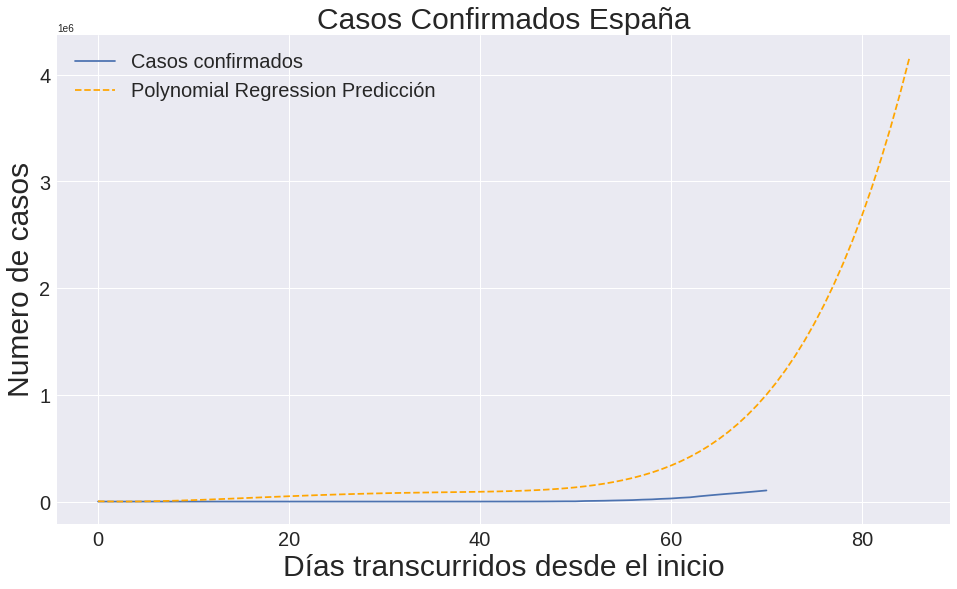

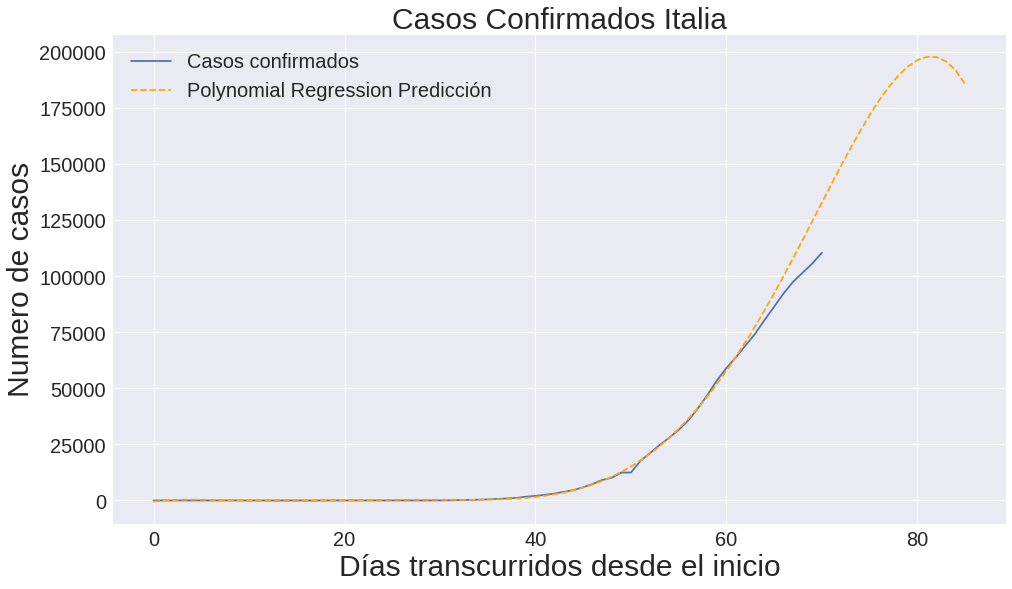

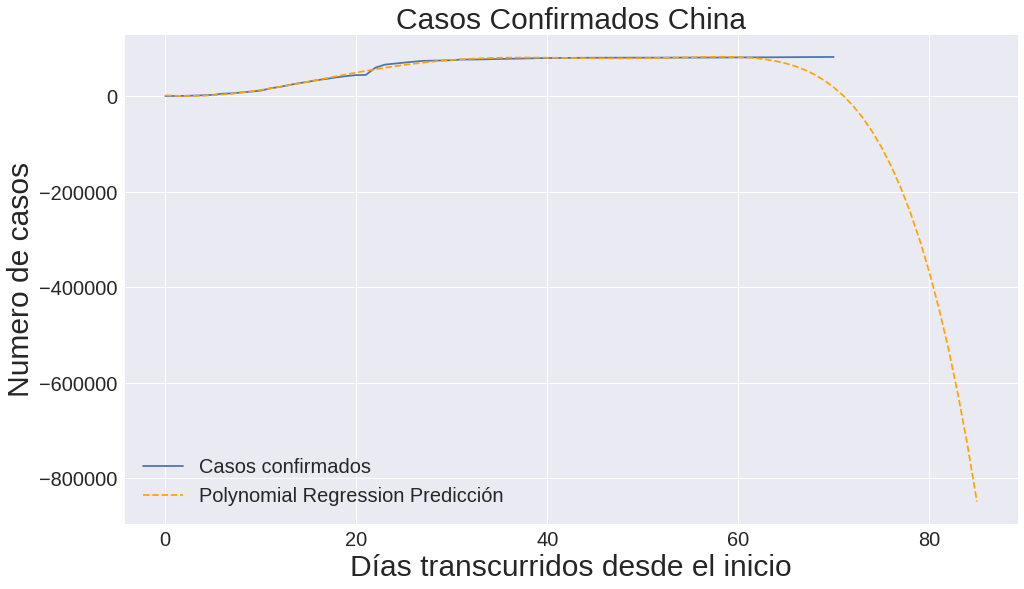

In [0]:
plt.figure(figsize=(16, 9))
plt.plot(ajuste_de_fechas_spain, casos_confirmados_spain)
plt.plot(prediccion_spain, linear_pred_spain, linestyle='dashed', color='orange')
plt.title('Casos Confirmados España', size=30)
plt.xlabel('Días transcurridos desde el inicio', size=30)
plt.ylabel('Numero de casos', size=30)
plt.legend(['Casos confirmados', 'Polynomial Regression Predicción'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()



plt.figure(figsize=(16, 9))
plt.plot(ajuste_de_fechas_italy, casos_confirmados_italy)
plt.plot(prediccion_italy, linear_pred_italy, linestyle='dashed', color='orange')
plt.title('Casos Confirmados Italia', size=30)
plt.xlabel('Días transcurridos desde el inicio', size=30)
plt.ylabel('Numero de casos', size=30)
plt.legend(['Casos confirmados', 'Polynomial Regression Predicción'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()



plt.figure(figsize=(16, 9))
plt.plot(ajuste_de_fechas_china, casos_confirmados_china)
plt.plot(prediccion_china, linear_pred_china, linestyle='dashed', color='orange')
plt.title('Casos Confirmados China', size=30)
plt.xlabel('Días transcurridos desde el inicio', size=30)
plt.ylabel('Numero de casos', size=30)
plt.legend(['Casos confirmados', 'Polynomial Regression Predicción'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()



Para casos por países vemos que no encaja bien este tipo de regresiones. En la segunda parte vemos como se estudian estos modelos

# **2º parte: Modelo SEIR**

En la segunda parte de este notebook se intenta analizar y predecir la propagación del COVID-19. Para ello se usa un modelo SEIR, ajustandolo con los datos existentes. Se intenta predecir cuando se dará el pico de contagios y de muertes. Se realizan dos modelos: uno sin niguna restricción para remediar la propagación. El segundo se toma unas restricciones ideales, ya que para las actuales restricciones tomadas se debería profundizar más

In [0]:
# Importamos las libreías necesarías para esta 2º parte

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image
import datetime as dt

In [0]:
#Cada fila de los df informa el número acumulativo de individuos para cada día.
# Las 4 primeras filas contienen datos geográficos


country = 'Spain'
cols = confirmed.columns[4:]
#infectados
infectados = confirmed.loc[confirmed['Country/Region']== country, cols].values.flatten()
#muertes
muertes = deaths.loc[deaths['Country/Region']== country, cols].values.flatten()
#recuperados
recuperados = recovered.loc[recovered['Country/Region']== country, cols].values.flatten()

In [0]:
# Visualizamos los datos en bruto con los que vamos a trabajar

dates = cols.values
x = [dt.datetime.strptime(d,'%m/%d/%y').date() for d in dates]

fig = go.Figure(data=go.Scatter(x=x, y=infectados,
                               mode='lines+markers',
                               name='Infectados'))
fig.add_trace(go.Scatter(x=x, y=muertes,
                    mode='lines+markers',
                    name='Muertes'))
fig.add_trace(go.Scatter(x=x, y=recuperados,
                    mode='lines+markers',
                    name='Recuperados'))
fig.update_layout(title='Evolución COVID-19 es España',
                   xaxis_title='Días',
                   yaxis_title='Número de individuos')
fig.show()

In [0]:
# Un vistazo nos permite en eliminar los datos que contienen cero y nos centramos en la propagación del virús
infectados

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      1,      1,      1,      1,      1,      1,
            1,      1,      2,      2,      2,      2,      2,      2,
            2,      2,      2,      2,      2,      2,      2,      2,
            2,      2,      6,     13,     15,     32,     45,     84,
          120,    165,    222,    259,    400,    500,    673,   1073,
         1695,   2277,   2277,   5232,   6391,   7798,   9942,  11748,
        13910,  17963,  20410,  25374,  28768,  35136,  39885,  49515,
        57786,  65719,  73235,  80110,  87956,  95923, 104118])

Observando los valores 1 y 2 los podemos considerar aislado. Se puede observar en las [noticias](https://www.redaccionmedica.com/secciones/sanidad-hoy/coronavirus-infectados-espana-y-evolucion-covid19-desde-origen-4148) que esos primero casos requirieron hospitalización leve. 
Nos centramos en los valores exponenciales

In [0]:
infectados_clean = infectados[34:]
muertes_clean = muertes[34:]
recuperados_clean = recuperados[34:]


## **Modelo de propagación**
Normalmente los modelados de enfermedades infecciosas se realiza normalmente por el modelo SEIR( [info ](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)). se divide a la población:






*   **S**usceptible
*   **E**xpuestos, son individuos que están infectados, pero no son transmisores todavia


*   **I**nfectados

*   **R**ecuperados: conjunto de las personas fallecidas o recuperadas







Los individuos se van desplazando por cada grupo como indica la figura siguiente:

![texto alternativo](https://www.idmod.org/docs/hiv/_images/SEIR-SEIRS.png)


$$\left\{ \begin{array}{lcr}
\frac{dS}{dt}=-\beta\frac{IS}{N}\\
\frac{dE}{dt}=\beta\frac{IS}{N}-\sigma E\\
\frac{dI}{dt}=\sigma E-\gamma I\\
\frac{dR}{dt}=\gamma I
\end{array}\right.$$

El comportamiento del modelo depende de los parámetros "beta", "gamma" y "sigma". Sus papeles son:

- **Infectious** rate $\beta$: Controla la tasa de propagación entre un individuo susceptible e infeccioso
- **Recovery** rate $\gamma$: Se determina por la duración media de la infección
- **Incubation** rate $\sigma$: Tasa de individuos latentes que se vuelven infecciosos. El periodo de incubación es: $1/\sigma$.

El número de reproducción $R_0$ se define como $R_0=\frac{\beta}{\gamma}$.

El distanciamiento social puede disminnuir el número de reproducción $R_0$ de la enfermedad.

Para recrear esas condiciones disminuyo de forma exponencial $\beta$:

$$\beta\left(t> t_q\right)=\beta\cdot\exp\left(-\alpha\cdot(t-t_q)\right)$$

$t_q$ es el momento en que se produce ese distanciamiento y $\alpha$ define la decadencia

In [0]:
def SEIR_q(t, y, beta, gamma, sigma, alpha, t_quarantine):
    """SEIR modelo epidémico.
        S: subsceptible
        E: exposed
        I: infected
        R: recovered
        
        N: total población(S+E+I+R)
        
        Distancia Social es adoptada cuando t>=t_quarantine.
    """
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    
    if(t>t_quarantine):
        beta_t = beta*np.exp(-alpha*(t-t_quarantine))
    else:
        beta_t = beta
    dS = -beta_t*S*I/N
    dE = beta_t*S*I/N - sigma*E
    dI = sigma*E - gamma*I
    dR = gamma*I
    return [dS, dE, dI, dR]

Esta función puede ser integrada con el comando scipy.integrate.solve_ivp ( [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)).

In [0]:
N = 100
beta, gamma, sigma, alpha = [2, 0.4, 0.1, 0.5]
t_q = 10
y0 = np.array([99, 0, 1, 0])
sol = solve_ivp(SEIR_q, [0, 100], y0, t_eval=np.arange(0, 100, 0.1), args=(beta, gamma, sigma, alpha, t_q))

fig = go.Figure(data=go.Scatter(x=sol.t, y=sol.y[0], name='Susceptible, con intervención',
                               line=dict(color=px.colors.qualitative.Plotly[0])))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[1], name='Expuesto,con intervención',
                        line=dict(color=px.colors.qualitative.Plotly[1])))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[2], name='Infectados, con intervención',
                        line=dict(color=px.colors.qualitative.Plotly[2])))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[3], name='Recuperados, con intervención',
                        line=dict(color=px.colors.qualitative.Plotly[3])))


beta, gamma, sigma, alpha = [2, 0.4, 0.1, 0.0]
t_q = 10
y0 = np.array([99, 0, 1, 0])
sol = solve_ivp(SEIR_q, [0, 100], y0, t_eval=np.arange(0, 100, 0.1), args=(beta, gamma, sigma, alpha, t_q))

fig.add_trace(go.Scatter(x=sol.t, y=sol.y[0], name='Susceptible, sin intervención',
                               line=dict(color=px.colors.qualitative.Plotly[0], dash='dash')))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[1], name='Expuesto, sin intervención',
                        line=dict(color=px.colors.qualitative.Plotly[1], dash='dash')))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[2], name='Infectado, sin intervención',
                        line=dict(color=px.colors.qualitative.Plotly[2], dash='dash')))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[3], name='Recuperado, sin intervención',
                        line=dict(color=px.colors.qualitative.Plotly[3], dash='dash')))

fig.update_layout(title='Modelo epidémico SEIR',
                 xaxis_title='Días',
                 yaxis_title='% Población')
fig.show()

Las restricciones, parametrizada por $\alpha$, muestra un efecto positivo en los infectados y expuestas en el momento y al final de la crisis.

Con todo esto podemos ajustar el modelo (podemos encontrar $\beta, \gamma, \sigma, \alpha$).

##Ajuste de modelo de datos
Para encontrar los parámetros optimos, se realizará a través de una optimización mono-objetiva. La función del objetivo es el error cuadrático medio entre la predicción del modelo y los datos históricos.

Observamos ciertas correspondencias entre los datos históricos y los resultados del modelo ( El número de infectados es igual a la suma de E e I; el número de fallecidos y recuperados es igual a R).


In [0]:
def fit_to_data(vec, t_q, N, test_size):
    beta, gamma, sigma, alpha = vec
    
    sol = solve_ivp(SEIR_q, [0, t_f], y0, args=(beta, gamma, sigma, alpha, t_q), t_eval=t_eval)
    
    split = np.int((1-test_size) * infectados_clean.shape[0])
    
    error = (
        np.sum(
            5*(muertes_clean[:split]+recuperados_clean[:split]-sol.y[3][:split])**2) +    
        np.sum(
            (infectados_clean[:split]-np.cumsum(sol.y[1][:split]+sol.y[2][:split]))**2)
    ) / split
    
    return error


### Condiciones iniciales 
Para proceder con el modelo hay que hacer unas suposiciones. Mientras que las condiciones iniciales pueden definirse mirando los datos, en cuanto al tamaño de la población hay que buscar fuera([datos INE](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176951&menu=ultiDatos&idp=1254735572981))

En españa la tasa de mortalidad se sitúa alrededor de 7,55%. Esto se debe a que las pruebas se realizan sólo a los individuos son probablemente positivos. Se calcula que realmente la tasa real de mortalidad está por debajo de 2% como en muchas C.C.A.A.([info](https://www.abc.es/salud/enfermedades/abci-cuantas-personas-mueren-realmente-coronavirus-202003311442_noticia.html)

Para intentar eliminar ese sesgo, la población la divido por 10/1.1

In [0]:
N = 47e6 / (7.55/2)
N = np.int(N)
t_q = 18 # se lleva a cabo cuarentena
t_f = infectados_clean.shape[0]
y0 = [N-infectados_clean[0], 0, infectados_clean[0], 0]
t_eval = np.arange(0,t_f,1)
test_size = 0.1

opt = minimize(fit_to_data, [2, 1, 0.8, 0.3], method='Nelder-Mead', args=(t_q, N, test_size))
beta, gamma, sigma, alpha = opt.x
sol = solve_ivp(SEIR_q, [0, t_f], y0, args=(beta, gamma, sigma, alpha, t_q), t_eval=t_eval)

In [0]:
fig = go.Figure(data=go.Scatter(x=x[34:], y=np.cumsum(sol.y[1]+sol.y[2]), name='E+I',
                               marker_color=px.colors.qualitative.Plotly[0]))
fig.add_trace(go.Scatter(x=x[34:], y=infectados_clean, name='Infectados', mode='markers', 
                         marker_color=px.colors.qualitative.Plotly[0]))
fig.add_trace(go.Scatter(x=x[34:], y=sol.y[3], name='R', mode='lines', 
                         marker_color=px.colors.qualitative.Plotly[1]))
fig.add_trace(go.Scatter(x=x[34:], y=muertes_clean+recuperados_clean, name='Muertes + Recuperados', 
                         mode='markers', 
                         marker_color=px.colors.qualitative.Plotly[1]))
fig.add_trace(go.Scatter(x=[x[53], x[53]], y=[0, 100000], name='Cuarentena', mode='lines',
                        marker_color='darkgrey'))
fig.update_layout(title='''Modelo prediccion vs datos historicos''',
                   xaxis_title='Días',
                   yaxis_title='Número individuos')

fig.show()

Como vemos si definimos mejor el error llevará a un mejor resultado. Los datos que hemos elegidos contiene demasiada información del sistema, que cambia dia tras dia. Ajustaremos el modelo a todos los datos y lo usaremos para la predicción

In [0]:
test_size = 0

opt = minimize(fit_to_data, [2, 1, 0.8, 0.3], method='Nelder-Mead', args=(t_q, N, test_size))
beta, gamma, sigma, alpha = opt.x
sol = solve_ivp(SEIR_q, [0, t_f], y0, args=(beta, gamma, sigma, alpha, t_q), t_eval=t_eval)

In [0]:
fig = go.Figure(data=go.Scatter(x=x[34:], y=np.cumsum(sol.y[1]+sol.y[2]), name='E+I',
                               marker_color=px.colors.qualitative.Plotly[0]))
fig.add_trace(go.Scatter(x=x[34:], y=infectados_clean, name='Infectados', mode='markers', 
                         marker_color=px.colors.qualitative.Plotly[0]))
fig.add_trace(go.Scatter(x=x[34:], y=sol.y[3], name='R', mode='lines', 
                         marker_color=px.colors.qualitative.Plotly[1]))
fig.add_trace(go.Scatter(x=x[34:], y=muertes_clean+recuperados_clean, name='Muertos + Recuperados', 
                         mode='markers', 
                         marker_color=px.colors.qualitative.Plotly[1]))
fig.add_trace(go.Scatter(x=[x[53], x[53]], y=[0, 100000], name='Cuarentena', mode='lines',
                        marker_color='darkgrey'))
fig.update_layout(title='''Modelo de predicción vs Datos históricos''',
                   xaxis_title='Días',
                   yaxis_title='Número de individuos')

fig.show()

##**Predicciones**
Procedemos a buscar el día en que será el pico

In [0]:
days_ahead = 45
new_x = x[34:] + [x[-1]+dt.timedelta(days=day) for day in range(1, days_ahead)]
t_eval = np.arange(0,t_f+days_ahead,1)
sol = solve_ivp(SEIR_q, [0, t_f+days_ahead], y0, args=(beta, gamma, sigma, alpha, t_q), t_eval=t_eval)

peak = new_x[np.argmax(sol.y[2])]

fig = go.Figure(data=go.Scatter(x=new_x, y=sol.y[1], name='E'))
fig.add_trace(go.Scatter(x=new_x, y=sol.y[2], name='I'))
fig.add_trace(go.Scatter(x=new_x, y=sol.y[3], name='R'))
fig.add_trace(go.Scatter(x=[peak, peak], y=[0, 5e4], name='Predicción pico', mode='lines',
             line=dict(color=px.colors.qualitative.Plotly[3], dash='dot')))
fig.update_layout(title='''Modelo de predicción''',
                   xaxis_title='Días',
                   yaxis_title='Número de individuos')
fig.show()

In [0]:
fig = go.Figure(data=go.Scatter(x=new_x, y=np.cumsum(sol.y[1]+sol.y[2]), name='Infectados'))
fig.add_trace(go.Scatter(x=new_x, y=sol.y[3], name='Muertes + Recuperados'))

fig.update_layout(title='''Modelo de predicción''',
                   xaxis_title='Días',
                   yaxis_title='Número de individuos')
fig.show()

Predecimos aproximadamente el número de fallecidos con la actual tasa de mortalidad(entre los infectados), que es alrededor del 27%([info](https://www.worldometers.info/coronavirus/country/spain/))

In [0]:
death_rate=.27

fig = go.Figure(data=go.Scatter(x=new_x, y=sol.y[3]*death_rate, name='Muertes (predicción)',
                               line=dict(color=px.colors.qualitative.Plotly[2])))
fig.add_trace(go.Scatter(x=x[30:], y=muertes_clean, name='Históricos', mode='markers',
                        marker_color=px.colors.qualitative.Plotly[3]))
fig.update_layout(title='Predicción muertes y datos históricos',
                   xaxis_title='Días',
                   yaxis_title='Número individuos')
fig.show()

Con el modelo podemos predecir algunas características del COVID-19, como el número reproductivo ** $R_0$ y el **periodo medio de incubación**.

Muestran una gran varianza, pero los valores medios están alrededor de $\bar{R_0}=2,5$ y $\bar{t_i}=3,0$ dias.



In [0]:
R_0 = beta / gamma
incubation = 1 / sigma

print('Estimación de número reproductivo: {:.2f}'.format(R_0))
print('Estimación media del período de incubación: {:.2f}'.format(incubation))

Estimación de número reproductivo: 2.12
Estimación media del período de incubación: 1.57


### Distancia Social

Este es un modelo simple que muestra lo efectiva que es lo que sucede si no se sigue una restricción de la distancia. Se añade un tiempo $t_{stop}$ en el que $\beta$ vuelve a su valor inicial

In [0]:
def SEIR_q_stop(t, y, beta, gamma, sigma, alpha, t_quarantine, t_stop):
    """SEIR epidemic model.
        S: subsceptible
        E: exposed
        I: infected
        R: recovered
        
        N: total population (S+E+I+R)
        
        Social distancing is adopted when t>t_quarantine and t<=t_stop.
    """
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    
    if(t>t_quarantine and t<=t_stop):
        beta_t = beta*np.exp(-alpha*(t-t_quarantine))
    else:
        beta_t = beta
    dS = -beta_t*S*I/N
    dE = beta_t*S*I/N - sigma*E
    dI = sigma*E - gamma*I
    dR = gamma*I
    return [dS, dE, dI, dR]

In [0]:
N = 100
beta, gamma, sigma, alpha = [2, 0.4, 0.1, 0.5]
t_q = 10
t_stop = 30
y0 = np.array([99, 0, 1, 0])
sol = solve_ivp(SEIR_q_stop, [0, 100], y0, t_eval=np.arange(0, 100, 0.1), args=(beta, gamma, sigma, alpha, t_q, t_stop))

fig = go.Figure(data=go.Scatter(x=sol.t, y=sol.y[0], name='Susceptible, interrumpido',
                               line=dict(color=px.colors.qualitative.Plotly[0])))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[1], name='Expuesto, interrumpido',
                        line=dict(color=px.colors.qualitative.Plotly[1])))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[2], name='Infectado, interrumpido',
                        line=dict(color=px.colors.qualitative.Plotly[2])))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[3], name='Recuperado, interrumpido',
                        line=dict(color=px.colors.qualitative.Plotly[3])))

t_stop = 200
sol = solve_ivp(SEIR_q_stop, [0, 100], y0, t_eval=np.arange(0, 100, 0.1), args=(beta, gamma, sigma, alpha, t_q, t_stop))

fig.add_trace(go.Scatter(x=sol.t, y=sol.y[0], name='Susceptible, continuado',
                               line=dict(color=px.colors.qualitative.Plotly[0], dash='dash')))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[1], name='Expuesto, continuado',
                        line=dict(color=px.colors.qualitative.Plotly[1], dash='dash')))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[2], name='Infectado, continados',
                        line=dict(color=px.colors.qualitative.Plotly[2], dash='dash')))
fig.add_trace(go.Scatter(x=sol.t, y=sol.y[3], name='Recuperado, continuado',
                        line=dict(color=px.colors.qualitative.Plotly[3], dash='dash')))

fig.update_layout(title='Modelo epidémico SEIR - efecto de la distancia social',
                 xaxis_title='Días',
                 yaxis_title='Porcentaje de la población')
fig.show()

**Conclusiones**

Se ha aplicado un modelo SEIR para ajustar los datos históricos de la propagación de COVID-19 en España. Los resultados muestran que vamos a experimentar el pico en estos días, y que para los próximos 30 días se espera un incremento en el número de individuos infectados, fallecidos y recuperados. Una prueba del modelo la constituyen las estimaciones tanto del número de reproductores como del período medio de incubación obtenido. Debe hacerse un estudio más sólido, estimando el intervalo de confianza considerando el efecto del sesgo introducido en los datos históricos con la política de restricciones seguidas en España

Nótese que las predicciones se basan en los supuestos de que se siguen estrictamente las restricciones de distanciamiento social. Para un estudio más profundo se deberia estudiar los parametros de las restricciones reales seguidas en España. Con estos mismos parámetros se puede estudiar cualquier país que este sufriendo la pandemia del COVID-19 #quedateencasa